# RTML Midterm 2021

1. In Lab 06, you fine tuned a Mask R-CNN model on the Cityscapes dataset. Download the image at http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg and run it through
   you model. Provide your source code to load the model, image, get the result, and display the result here. Display the resulting bounding boxes and masks. 

In [2]:
# Code to load model, image, and display result here
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

import utils
from coco_utils_city import get_city_inference
import transforms

# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
model.load_state_dict(torch.load('city_weights/mask-rcnn-09-epochs.pth'))
model.eval()


Loading pretrained model...


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [3]:
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms, datasets
compose = transforms.Compose(
    [
        transforms.Resize(1000),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])

ds = torchvision.datasets.ImageFolder(root='inference_pics', transform=compose)

def collate_fn(batch):
    return tuple(zip(*batch))

val_dataloader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [4]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:2


In [5]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [6]:
images, targets = next(iter(val_dataloader))

# print(type(images), len(images))
# print(images[0].shape)
# print(type(targets), len(targets))
# print(targets[0].keys())
# # print()
# images = images.to(device)

images = [ img.to(device) for img in images ]
predictions = model(images)

# print('Prediction keys:', list(dict(predictions[0])))
# print('Boxes shape:', predictions[0]['boxes'].shape)
# print('Labels shape:', predictions[0]['labels'].shape)
# print('Scores shape:', predictions[0]['scores'].shape)
# print('Masks shape:', predictions[0]['masks'].shape)

In [7]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

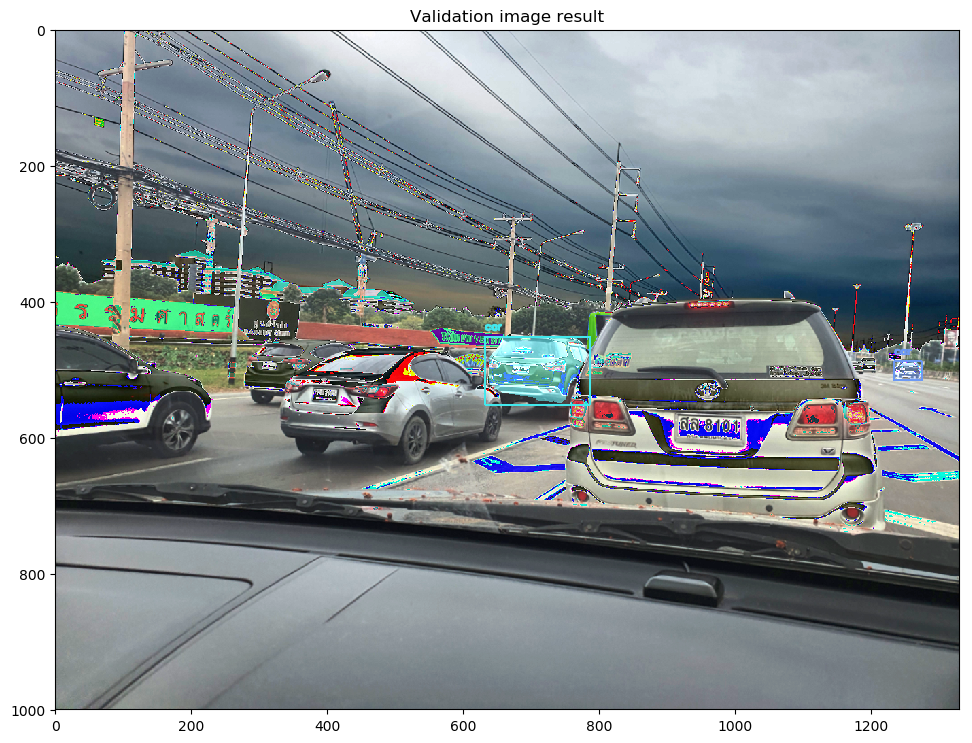

In [9]:

from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

2. Write a program that samples 1000 points from a mixture of 4 2D Gaussians with identity covariance centered at (5,5), (10,5), (5,10), and (10,10).
   Provide the code and a plot of the sample.

In [14]:
class make_data():
    
    def __init__(self, mean1,mean2,mean3,mean4,cov, num_sample):
        self.mean1 = mean1
        self.mean2 = mean2
        self.mean3 = mean3
        self.mean4 = mean4
        self.cov = cov
        self.num_sample = num_sample
        self.data1 = np.random.multivariate_normal(self.mean1, self.cov, 250)
        self.data2 = np.random.multivariate_normal(self.mean2, self.cov, 250)
        self.data3 = np.random.multivariate_normal(self.mean3, self.cov, 250)
        self.data4 = np.random.multivariate_normal(self.mean4, self.cov, 250)
        self.data = np.concatenate((self.data1,self.data2,self.data3,self.data4),axis = 0)
        self.len = self.data.shape[0]
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

In [15]:
mean1 = (5, 5)
mean2 = (10,5)
mean3 = (5,10)
mean4 = (10,10)
cov = [[1, 0], [0,1]]
num_sample = 1000
dataset = make_data(mean1,mean2,mean3,mean4,cov,num_sample)

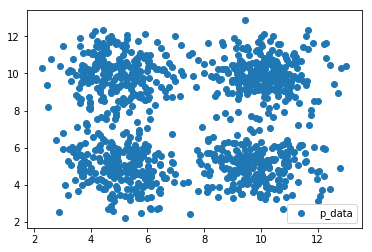

In [16]:
plt.scatter(dataset.data[:,0],dataset.data[:,1],label = 'p_data')
plt.legend()

3. Write a GAN generator G and discriminator D to model the dataset you generated in Question 2. Train the GAN and display two plots: a fake sample from the generator and the original sample from Question 2.

In [17]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [18]:
from torch import nn, optim
data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
num_batches = len(data_loader)
print('num_batches: ', num_batches)

num_batches:  100


In [19]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        n_classes = 4
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            #nn.Tanh() #Tanh because output image = [0,1]
        )

    def forward(self, x):
        #print("generator")
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

In [20]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        #print("discriminator")
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x
    
# def images_to_vectors(images):
#     return images.view(images.size(0), 784)

# def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)

In [21]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

if torch.cuda.is_available():
    discriminator.cuda(device)
    generator.cuda(device)

Configured device:  cuda:2


In [22]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 100

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

In [23]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)

In [24]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data.float())
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data.float())
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [25]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data.float())
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [26]:
# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 2) #[size vector of length 100]
    if torch.cuda.is_available(): return n.cuda(device) 
    return n

num_test_samples = 200
test_noise = noise(num_test_samples)

In [27]:
def plt_output(fake_data,real_data):
    plt.figure(figsize=(4,4))
    plt.scatter(fake_data[:,0], fake_data[:,1],label = 'p_x')
    plt.scatter(real_data.data[:,0], real_data.data[:,1],label = 'p_data')
    plt.legend()
    plt.show()

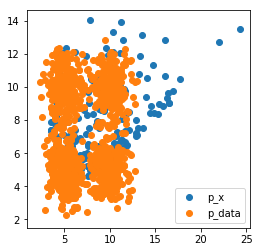

Epoch: [99/100], Batch Num: [95/100]
Discriminator Loss: 1.3923, Generator Loss: 0.7060
D(x): 0.4986, D(G(z)): 0.5004


In [28]:

logger = Logger(model_name='VGAN', data_name='Midterm')

d_loss = []
g_loss = []

for epoch in range(num_epochs):
    for n_batch, real_batch in enumerate(data_loader):
        # Train discriminator on a real batch and a fake batch
        
        #real_data = images_to_vectors(real_batch)
        real_data = real_batch
        real_data = real_data.cuda(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        d_loss.append(d_error)
        g_loss.append(g_error)
        
        # Log errors and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 5 == 0:
            display.clear_output(True)
            # Display Images
            test_plot = plt_output(generator(test_noise).cpu().detach().numpy(),dataset)
            #logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

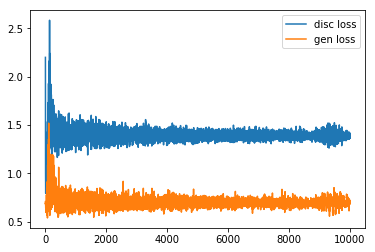

In [29]:
plt.plot(d_loss, label = 'disc loss')
plt.plot(g_loss, label = 'gen loss')
plt.legend()
plt.show()

#### Results

Obviously, the results shown above seem odd. Despite the convergence of the two losses, the model still does not perform well when judged by eye. That is because the model cannot distinguish between the 4 distributions of having the same cov and different means.

My attempt to solve such problem is to also include another MSELoss which would take care of the clustering. 

To do so i need to modify my make_data function to also output the means of the 4 clusters

class make_data():
    
    def __init__(self, mean1,mean2,mean3,mean4,cov, num_sample):
        self.mean1 = mean1
        self.mean2 = mean2
        self.mean3 = mean3
        self.mean4 = mean4
        self.cov = cov
        self.num_sample = num_sample
        self.data1 = np.random.multivariate_normal(self.mean1, self.cov, 250)
        self.data2 = np.random.multivariate_normal(self.mean2, self.cov, 250)
        self.data3 = np.random.multivariate_normal(self.mean3, self.cov, 250)
        self.data4 = np.random.multivariate_normal(self.mean4, self.cov, 250)
        self.data = np.concatenate((self.data1,self.data2,self.data3,self.data4),axis = 0)
        self.mean = np.concatenate((self.mean1,self.mean2,self.mean3,self.mean4),axis = 0)
        self.len = self.data.shape[0]
    def __getitem__(self, index):
        return self.data[index], self.mean[index]

    def __len__(self):
        return self.len

I would also need to modify my Generator function to output both the generated image as well as the cluster information. As i planned it it should be as follows:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        n_classes = 4
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features + n_classes, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            #nn.Tanh() #Tanh because output image = [0,1]
        )
        self.out2 = nn.Linear(256,n_classes)

    def forward(self, x):
        #print("generator")
        x = self.hidden0(x)
        x = self.hidden1(x)
        out1 = self.out(x)
        out2 = self.out2(x)
        out2 = torch.softmax(out2, dim = 1)
        return out1,out2

As for the discriinator, it can be the same

Of course, i would need two types of losses 

loss1 = nn.BCELoss() <br>
loss2 = nn.MSELoss()


To train my generator, i would need to include both loss terms

def train_generator(optimizer, fake_data, predicted_cluster, means):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data.float())
    error = loss1(prediction, real_data_target(prediction.size(0)))
    error2 = loss2(predicted_cluster,means)
    
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

and As for the training, i would need to also feed in information about the means of each 4 clusters into my train_generator, so that it can calculate the MSEloss!

for epoch in range(num_epochs):
    for n_batch, (real_batch, means) in enumerate(data_loader):
        # Train discriminator on a real batch and a fake batch
        
        #real_data = images_to_vectors(real_batch)
        real_data = real_batch
        real_data = real_data.cuda(device)
        fake_data, _ = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data, predicted_cluster = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data, predicted_cluster, means)
        
        d_loss.append(d_error)
        g_loss.append(g_error)
        
        # Log errors and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 5 == 0:
            display.clear_output(True)
            # Display Images
            test_plot = plt_output(generator(test_noise).cpu().detach().numpy(),dataset)
            #logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

If i'm not wrong this is method is adapted from the *"ClusterGAN"*

4. Suppose you are working on a regression problem for which you have insufficient data and come up with the idea of
   using a GAN to generate new $(\mathbf{x},y)$ pairs. First explain precisely how
   this could be done, then explain why it would be a bad idea.

*Your answer here*

In order to generate new (x,y) pair, i would like to start with constructing an autoencode, train it to be able to construct output to be as close as the real input as possible. This will include fc layers for both encoder as well as the decoder. The activation fuctions will need to be determined unpon the nature of the input data (which will problally be ReLU). I will also include DropOut as a  regularizer. As for the loss function, i will start of with testing out the MSE loss and as for the opmizer i will choose Adam. After evaluating my AE, i will proceed on the next steps.

Afterwards, i would take AE bottleneck layer together with the generated noise and feed it into my GAN network. Again, GANs will also include fc layers. The key idea here is the loss function of my GAN, since my discriminator predicts whether the generated data is real or fake, the loss function will stay the same. However, for the generator, it generates data as well as predicting the actual value, on top of the normal loss function, it will also include MSE loss function which takes care of whether it can predict the correct value of the regression problem. 

This is a bad idea, because it can be imprecise. If getting the real data is possible, it is probalby  a better idea. In the real case, forecxample in EEG, EEG data is hard to find, people seek to generate EEG data. However, it is not as good when modeling it. 


5. Briefly explain the purpose of weight decay and weight clipping, including how they are similar and how they are different.

*Your answer here*

Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function. It is used to prevent overfitting and To keep the weights small and avoid exploding gradient. Because the L2 norm of the weights are added to the loss, each iteration of your network will try to optimize/minimize the model weights in addition to the loss. This will help keep the weights as small as possible, preventing the weights to grow out of control, and thus avoid exploding gradient.

On the other hand, weight clipping behaves as a weight regulation.  It reduces the capacity of the model and limits the capability to model complex functions. 

They are similar in a way that they act as a regularizers for the networks, and difference in a way that is weight decay slowly decays the value of the weights, but weight clipping only restricts the maximum value of the weights can  be.
